# group level for Social Prediction

*Yiyu Wang 2024 Feb*


In [3]:
import os

import glob
import nibabel as nib
import numpy as np
import pandas as pd
import copy

import nilearn
from nilearn.image import smooth_img, resample_to_img,new_img_like, math_img, concat_imgs, get_data
from nilearn import image
from nilearn import plotting
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from scipy.stats import norm

from nilearn.datasets import load_mni152_gm_mask,load_mni152_wm_mask,fetch_surf_fsaverage


import gzip
import math

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
# local directory set up
gm_mask_img = nib.load('masks/gm_mask_icbm152_brain.nii.gz')

subjects_list = pd.read_csv('Data/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )


TR = .001
N_TR = 675
TR_Length = 0.8
TR_IN_MS = int(TR_Length/TR)

fwhm = 0


subjects in this analysis:
[152, 179, 154, 158, 173, 153, 159, 174, 162, 145, 143, 181, 144, 169, 146, 167, 161, 182, 147, 166, 160, 185, 170, 176, 151, 157, 171, 177, 150, 156]
**** n = 30 *****


In [5]:
logfile_headers =np.array(['obs_video_name', 'fd_video_name','video_number','trial_condition','run_number','run_condition',
             'obs_video_onset','obs_video_offset','obs_video_duration_method1','obs_video_duration_method2',
             'prediction','prediction_x','prediction_y','prediction_RT','prediction_onset', 
             'fb_video_onset','fb_video_offset','fb_video_duration_method1','fb_video_duration_method2',
             'surprise','surprise_RT','surprise_onset'])

In [6]:


beta_dir = 'model_norating_fmri_results/1stLvl/'
second_level_res_dir = 'model_norating_fmri_results/PairedT_2ndlvl/'
if not os.path.isdir(second_level_res_dir):
    os.mkdir(second_level_res_dir)


vmax = 5
cluster_thre = 30
p_val = 0.05
p_unc = norm.isf(p_val)

p001 = 0.001
p001_unc = norm.isf(p001)

alpha = 0.05

In [7]:
# make inputs for second level model
file_list = []
social_pattern_contrast = []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*obs_Pattern*.nii.gz')
    file_list.append(file_name[0])
    social_pattern_contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*obs_Social*.nii.gz')
    file_list.append(file_name[0])
    social_pattern_contrast.append(1)

   
second_level_input = file_list
n_subjects = len(subjects_list)
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects_reg = [f'S{i}' for i in subjects_list]

design_columns = ['intercept','obs_social_pattern']

X = pd.concat([pd.Series(np.ones(len(file_list))), pd.Series(social_pattern_contrast)], axis=1)
X = pd.DataFrame(np.hstack((X, subject_effect)),columns= design_columns + subjects_reg)

second_level_input = file_list
second_level_model = SecondLevelModel(mask_img=gm_mask_img)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)



plotting.plot_design_matrix(X, output_file=join(second_level_res_dir, f'design_matrix.png'))

In [17]:
group_res = second_level_model.compute_contrast('obs_social_pattern',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/obs_social_pattern_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)


In [18]:
z_map = nib.load(second_level_res_dir + f'/obs_social_pattern_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')
print('problem with social - pattern obs video, no voxels survice fwe correction')

fwe corrected at 5.8395071406529695
max voxel value: 4.68770489785647
problem with social - pattern obs video, no voxels survice fwe correction


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 4.68770489785647. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


In [19]:
# [PE – congruent] in the social run only

# make inputs for second level model
file_list = []
contrast = []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_Congruent*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_PE*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(1)

   
second_level_input = file_list
n_subjects = len(subjects_list)
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects_reg = [f'S{i}' for i in subjects_list]

design_columns = ['intercept','fb_social_PE_congruent']

X = pd.concat([pd.Series(np.ones(len(file_list))), pd.Series(contrast)], axis=1)
X = pd.DataFrame(np.hstack((X, subject_effect)),columns= design_columns + subjects_reg)

second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)



In [20]:
group_res = second_level_model.compute_contrast('fb_social_PE_congruent',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/fb_social_PE_congruent_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)


In [21]:
z_map = nib.load(second_level_res_dir + f'/fb_social_PE_congruent_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')
print('problem with social PE-congruent video, no voxels survice fwe correction (the max voxel value was 0.01 lower)')


fwe corrected at 5.8395071406529695
max voxel value: 4.626035198820533
problem with social PE-congruent video, no voxels survice fwe correction (the max voxel value was 0.01 lower)


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 5.017728254482691. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


In [22]:
# [PE – congruent] in the pattern run only

# make inputs for second level model
file_list = []
contrast = []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_Congruent*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_PE*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(1)

   
second_level_input = file_list
n_subjects = len(subjects_list)
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects_reg = [f'S{i}' for i in subjects_list]

design_columns = ['intercept','fb_pattern_PE_congruent']

X = pd.concat([pd.Series(np.ones(len(file_list))), pd.Series(contrast)], axis=1)
X = pd.DataFrame(np.hstack((X, subject_effect)),columns= design_columns + subjects_reg)

second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)




In [23]:
group_res = second_level_model.compute_contrast('fb_pattern_PE_congruent',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/fb_pattern_PE_congruent_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)


In [24]:
z_map = nib.load(second_level_res_dir + f'/fb_pattern_PE_congruent_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')

fwe corrected at 5.8395071406529695
max voxel value: 4.034110983738506


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 4.034110983738506. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


In [25]:
# [PE – congruent] in the social run + [PE – congruent] in the pattern run
# PE - congruent cotrast, collapsing the conditions

# make inputs for second level model
file_list = []
contrast = []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_Congruent*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_Congruent*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_PE*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_PE*.nii.gz')
    file_list.append(file_name[0])
    contrast.append(1)
   
second_level_input = file_list
n_subjects = len(subjects_list)
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects),np.eye(n_subjects),np.eye(n_subjects)))
subjects_reg = [f'S{i}' for i in subjects_list]

design_columns = ['intercept','fb_PE_congruent']

X = pd.concat([pd.Series(np.ones(len(file_list))), pd.Series(contrast)], axis=1)
X = pd.DataFrame(np.hstack((X, subject_effect)),columns= design_columns + subjects_reg)

second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)


In [26]:
group_res = second_level_model.compute_contrast('fb_PE_congruent',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/fb_PE_congruent_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)


In [27]:
z_map = nib.load(second_level_res_dir + f'/fb_PE_congruent_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')

fwe corrected at 5.8395071406529695
max voxel value: 2.9862747142842863


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 2.9862747142842863. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


In [28]:
# [PE – congruent] in the social run - [PE – congruent] in the pattern run
#  make a 2x2 ANOVA, and use the interaction:

# make inputs for second level model
file_list = []
main_condition_contrast, main_PE_contrast, interaction_contrast = [], [], []
# social = 1, pattern = -1, congruent = -1, PE = 1
# 
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_PE*.nii.gz')
    file_list.append(file_name[0])
    main_condition_contrast.append(1)
    main_PE_contrast.append(1) 
    interaction_contrast.append(1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Social_Congruent*.nii.gz')
    file_list.append(file_name[0])
    main_condition_contrast.append(1)
    main_PE_contrast.append(-1) 
    interaction_contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_PE*.nii.gz')
    file_list.append(file_name[0])
    main_condition_contrast.append(-1)
    main_PE_contrast.append(1) 
    interaction_contrast.append(-1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*beta*fb_Pattern_Congruent*.nii.gz')
    file_list.append(file_name[0])
    main_condition_contrast.append(-1)
    main_PE_contrast.append(-1) 
    interaction_contrast.append(1)


   
second_level_input = file_list
n_subjects = len(subjects_list)
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects),np.eye(n_subjects),np.eye(n_subjects)))
subjects_reg = [f'S{i}' for i in subjects_list]
design_columns = ['intercept','main_condition','main_PE','interaction']

X = pd.concat([pd.Series(np.ones(len(file_list))), 
               pd.Series(main_condition_contrast), 
               pd.Series(main_PE_contrast), 
               pd.Series(interaction_contrast)], axis=1)
X = pd.DataFrame(np.hstack((X, subject_effect)),columns= design_columns + subjects_reg)

second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)


In [29]:
group_res = second_level_model.compute_contrast('interaction',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/interaction_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)


In [30]:
z_map = nib.load(second_level_res_dir + f'/interaction_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')

fwe corrected at 5.8395071406529695
max voxel value: 4.298413973073893


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 4.750546754630983. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


In [31]:
# check if condition main effecit is similar to PE_congruent contrast for sanity check:

group_res = second_level_model.compute_contrast('main_PE',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/main_PE_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)



In [32]:
z_map = nib.load(second_level_res_dir + f'/main_PE_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')

fwe corrected at 5.8395071406529695
max voxel value: 2.9613670093291087


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 2.9613670093291087. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:439: UserWarning: empty mask
  new_img_like(img, not_mask, affine)


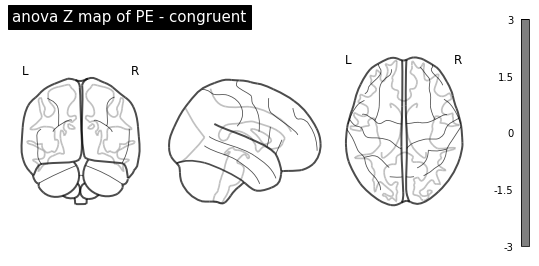

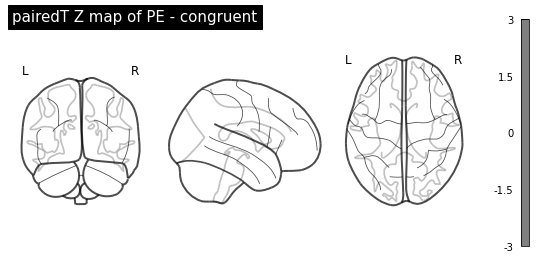

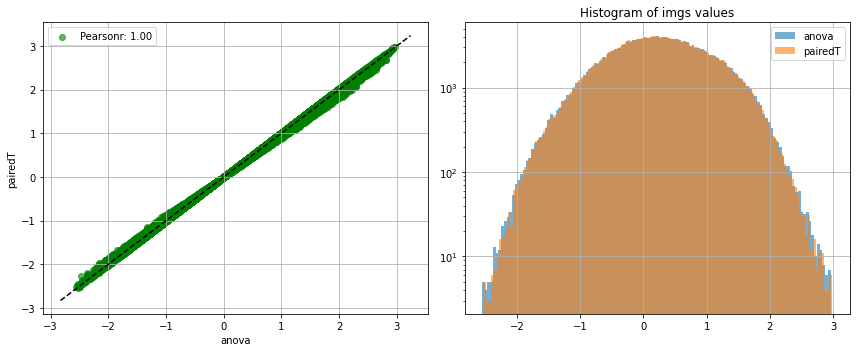

In [33]:
z_map_anova = nib.load(second_level_res_dir + f'/main_PE_z_score.nii.gz')
z_map_pairedT = nib.load(second_level_res_dir + f'/fb_PE_congruent_z_score.nii.gz')

import matplotlib.pyplot as plt
from scipy.stats import norm

plotting.plot_glass_brain(
    z_map_anova,
    colorbar=True,
    threshold=norm.isf(0.001),
    title='anova Z map of PE - congruent',
    plot_abs=False,
    display_mode="ortho",
)
plotting.plot_glass_brain(
    z_map_pairedT,
    colorbar=True,
    threshold=norm.isf(0.001),
    title='pairedT Z map of PE - congruent',
    plot_abs=False,
    display_mode="ortho",
)
plt.show()
masker = NiftiMasker(mask_img=gm_mask_img, standardize=False).fit(z_map_anova)

from nilearn.plotting import plot_img_comparison

plot_img_comparison(
    [z_map_anova], [z_map_pairedT], masker, ref_label="anova", src_label="pairedT"
)
plt.show()

In [34]:
# check if condition main effecit is similar to PE_congruent contrast for sanity check:

group_res = second_level_model.compute_contrast('main_condition',output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'/main_condition_{stats_name}.nii.gz'
    nib.save(res, nii_file_path)



In [35]:
z_map = nib.load(second_level_res_dir + f'/main_condition_z_score.nii.gz')
fwe_corrected_img, fwe = threshold_stats_img(z_map, mask_img=gm_mask_img, threshold=0.05, cluster_threshold=30, height_control='bonferroni')

print(f'fwe corrected at {fwe}')
print(f'max voxel value: {z_map.get_fdata().max()}')

fwe corrected at 5.8395071406529695
max voxel value: 5.379179773516442


/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 5.379179773516442. But, you have given threshold=5.8395071406529695.
  f"The given float value must not exceed {value_check}. "


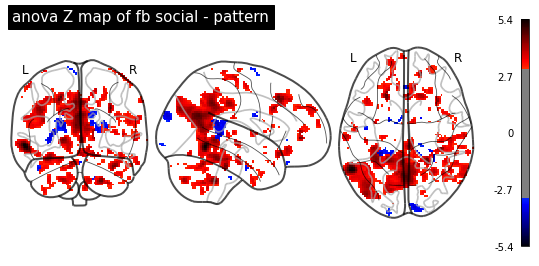

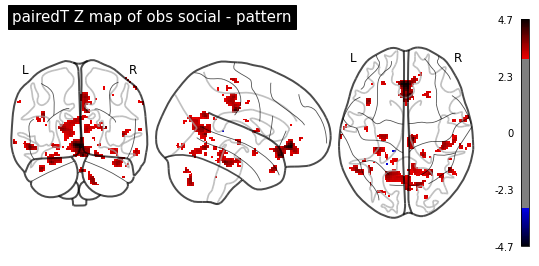

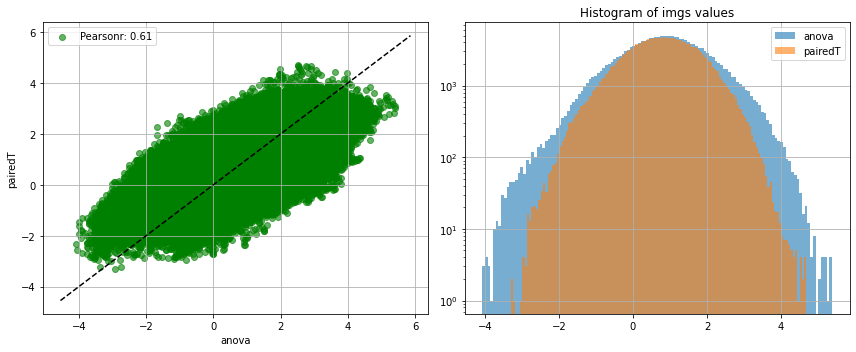

In [36]:
z_map_anova = nib.load(second_level_res_dir + f'/main_condition_z_score.nii.gz')
z_map_pairedT = nib.load(second_level_res_dir + f'/obs_social_pattern_z_score.nii.gz')

import matplotlib.pyplot as plt
from scipy.stats import norm

plotting.plot_glass_brain(
    z_map_anova,
    colorbar=True,
    threshold=norm.isf(0.001),
    title='anova Z map of fb social - pattern',
    plot_abs=False,
    display_mode="ortho",
)
plotting.plot_glass_brain(
    z_map_pairedT,
    colorbar=True,
    threshold=norm.isf(0.001),
    title='pairedT Z map of obs social - pattern',
    plot_abs=False,
    display_mode="ortho",
)
plt.show()
masker = NiftiMasker(mask_img=gm_mask_img, standardize=False).fit(z_map_anova)

from nilearn.plotting import plot_img_comparison

plot_img_comparison(
    [z_map_anova], [z_map_pairedT], masker, ref_label="anova", src_label="pairedT"
)
plt.show()